In [1]:
"""
Machine Learning Weather Analogue Search
=======================================

This notebook implements machine learning-based methods for finding weather analogues
using the Atmodist model. It extracts embeddings from weather data and performs
similarity searches to find historical weather patterns similar to target events.

Key components:
- Loading and preprocessing ERA5 reanalysis data
- Extracting embeddings using a pre-trained Atmodist model
- Searching for analogues using embedding-based similarity metrics
- Filtering and refining analogue results
- Visualizing and analyzing the found analogues
"""

# Standard library imports
import copy
import datetime
import json
import math
import os
import sys
from pathlib import Path

# Data handling and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For model loading and inference
import pytorch_lightning as pl


In [2]:
def setup_environment():
    """
    Set up the project environment by configuring paths and importing project modules.
    
    Returns:
        str: Current working directory
    """
    try:
        # Navigate to project root directory
        os.chdir("../")
    except Exception as e:
        print(f"Error changing directory: {e}")
    
    # Get and print current working directory
    current_directory = os.getcwd()
    print(f"Current Directory: {current_directory}")
    
    # Add project paths to sys.path
    sys.path.append(os.path.abspath(os.path.join(current_directory, "notebooks")))
    
    return current_directory

# Set up environment
current_directory = setup_environment()

# Import project modules
from models.atmodist_revised import Atmodist
from data.dataset import AtmodistDataset
from utils.utils import set_working_directory, load_json_config
from utils.utils_data import read_netcdf
from utils.utils_parsers import batch_data_parser, model_parser, feature_map_parser, process_in_batches, read_results
from utils.utils_analog import (
    generate_time_weights, search_analogs_atmodist, search_analogs, 
    revise_analogs, attach_data_to_analogs, plot_analogs, plot_analogs_with_band
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (10, 6),
})


Current Directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue


## Data Loading and Preprocessing

In this section, we load and preprocess the weather data and historical event information.

### Load ERA5 Reanalysis Data

We load preprocessed ERA5 reanalysis data with logarithmic scaling and apply weighting.

In [3]:
def load_era5_data(variable_list, freq, time_unit, method, preprocessing, years):
    """
    Load ERA5 reanalysis data based on specified parameters.
    
    Args:
        variable_list (list): List of variable names
        freq (int): Temporal frequency
        time_unit (str): Time unit ('h' for hours, 'd' for days)
        method (str): Resampling method
        preprocessing (str): Preprocessing method ('standardized', 'log', etc.)
        years (tuple): Start and end years (inclusive)
        
    Returns:
        tuple: (all_data, timestamps, tensor_data)
            - all_data: List of (timestamp, data_array) tuples
            - timestamps: List of timestamps
            - tensor_data: PyTorch tensor of data arrays
    """
    # Join variable names
    variables = ''.join(variable_list)
    
    # Construct file path
    file_path = f"../data/processed/{variables}_{freq}{time_unit}_{method}_{preprocessing}_{years[0]}{years[1]}_weighted.h5"
    print(f"Loading data from: {file_path}")
    
    try:
        # Load data
        all_data = read_netcdf(file_path)
        print(f"Data loaded successfully with {len(all_data)} time points")
        
        # Extract timestamps and data arrays
        timestamps = []
        data_arrays = []
        for item in all_data:
            timestamps.append(item[0])
            data_arrays.append(item[1])
        
        # Convert to numpy array and then to PyTorch tensor
        data_arrays = np.array(data_arrays, dtype=np.float32)
        tensor_data = torch.from_numpy(data_arrays)
        
        return all_data, timestamps, tensor_data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Data parameters
VARIABLE_LIST = ["d2m", "u", "v", "msl", "r"]
FREQUENCY = 1  # Hourly data
TIME_UNIT = "h"  # Hours
RESAMPLE_METHOD = "none"  # No resampling
PREPROCESSING = "log"  # Logarithmic scaling
YEAR_RANGE = (2004, 2020)  # Study period

# Load ERA5 data
all_variables_data, timestamps, atmosphere_data_tensor = load_era5_data(
    VARIABLE_LIST, FREQUENCY, TIME_UNIT, 
    RESAMPLE_METHOD, PREPROCESSING, YEAR_RANGE
)

# Print data information
print(f"Data shape: {atmosphere_data_tensor.shape}")
print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
print(f"Variables: {VARIABLE_LIST}")

Loading data from: ../data/processed/d2muvmslr_1h_none_log_20042020_weighted.h5
Data loaded successfully with 146736 time points
Data shape: torch.Size([146736, 5, 32, 32])
Time range: 2004-04-06T00:00:00.000000000 to 2020-12-31T23:00:00.000000000
Variables: ['d2m', 'u', 'v', 'msl', 'r']


### Load Historical Event Data

We load historical flood events that will be used as targets for analogue searching.

In [4]:
def load_events(file_path):
    """
    Load historical events from a CSV file.
    
    Args:
        file_path (str): Path to the events CSV file
        
    Returns:
        pandas.DataFrame: DataFrame containing event information
    """
    try:
        # Read events CSV file
        events_df = pd.read_csv(file_path)
        
        # Sort events by rank
        events_df = events_df.sort_values(by="Rank")
        
        # Convert date strings to datetime objects
        events_df["start datetime"] = pd.to_datetime(events_df["start datetime"])
        events_df["end datetime"] = pd.to_datetime(events_df["end datetime"])
        
        # Calculate event duration
        events_df["duration_hours"] = (events_df["end datetime"] - 
                                      events_df["start datetime"]).dt.total_seconds() / 3600
        
        return events_df
    except Exception as e:
        print(f"Error loading events: {e}")
        return None

# Load historical flood events
events_path = "data/raw/events_flood.csv"
events_df = load_events(events_path)

# Display event information
print(f"Loaded {len(events_df)} historical events")
print(f"Event time range: {events_df['start datetime'].min()} to {events_df['end datetime'].max()}")
print(f"Average event duration: {events_df['duration_hours'].mean():.1f} hours")

# Display the first few events
events_df.head()

Loaded 157 historical events
Event time range: 2005-07-04 03:00:00 to 2017-07-12 00:00:00
Average event duration: 21.1 hours


,Rank,ID,start datetime,end datetime,duration,duration_hours
0,1,2464,2014-07-08 10:00:00,2014-07-08 20:00:00,10.0,10.0
1,2,632,2006-08-29 11:00:00,2006-08-29 14:00:00,3.0,3.0
2,3,1998,2012-07-18 05:00:00,2012-07-19 04:00:00,23.0,23.0
3,4,481,2005-12-31 20:00:00,2006-01-01 04:00:00,8.0,8.0
4,5,2879,2016-04-04 06:00:00,2016-04-04 16:00:00,10.0,10.0


## Feature Extraction with Atmodist Model

In this section, we use a pre-trained Atmodist model to extract feature embeddings from the weather data.
These embeddings capture the essential patterns in the atmosphere and will be used for similarity searches.

### Model Loading and Embedding Generation

We load a pre-trained Atmodist model and use it to generate embeddings for all time points in our dataset.

In [5]:
class ModelWrapper(nn.Module):
    """
    Wrapper class for extracting features from a specific part of the model.
    
    This wrapper extracts the embedding features from the encoder part of the
    Atmodist model, which can then be used for similarity searches.
    
    Args:
        original_model: The loaded Atmodist model
    """
    def __init__(self, original_model):
        super(ModelWrapper, self).__init__()
        # Extract the encoder part of the model (first component)
        children = list(original_model.children())
        specific_stage = children[0]
        self.part_of_model = specific_stage

    def forward(self, x):
        """Extract embeddings from the input data"""
        return self.part_of_model(x)

def load_model_and_generate_embeddings(model_path, data_tensor, batch_size=1000):
    """
    Load a pre-trained model and generate embeddings for the input data.
    
    Args:
        model_path (str): Path to the model checkpoint
        data_tensor (torch.Tensor): Input data tensor
        batch_size (int): Batch size for processing
        
    Returns:
        numpy.ndarray: Embedding features for all input data
    """
    print(f"Loading model from: {model_path}")
    
    try:
        # Load the model
        model = model_parser(Atmodist, model_path, False)
        
        # Wrap the model to extract features
        feature_extractor = ModelWrapper(model)
        feature_extractor.eval()  # Set to evaluation mode
        
        print(f"Model loaded successfully. Generating embeddings...")
        
        # Process data in batches to generate embeddings
        process_in_batches(feature_extractor, data_tensor, batch_size)
        
        # Read the embedding results
        embeddings = read_results()
        
        # Reshape embeddings to 2D array
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
        
        print(f"Embeddings generated successfully with shape: {embeddings.shape}")
        return embeddings
    
    except Exception as e:
        print(f"Error in model loading or embedding generation: {e}")
        return None

# Model checkpoint path
MODEL_CHECKPOINT = "/home/yuhan/Desktop/Master/models/Atmodist/Formal/checkpoints/Formal-7-d2muvmslr-3h45-none-log-epoch=233-val_acc=0.35.ckpt"

# Generate embeddings
embeddings = load_model_and_generate_embeddings(
    model_path=MODEL_CHECKPOINT,
    data_tensor=atmosphere_data_tensor,
    batch_size=1000
)

# Display embedding information
"""print(f"Final embedding shape: {embeddings.shape}")
print(f"Embedding statistics:")
print(f"  - Mean: {embeddings.mean():.4f}")
print(f"  - Std: {embeddings.std():.4f}")
print(f"  - Min: {embeddings.min():.4f}")
print(f"  - Max: {embeddings.max():.4f}")"""

# Rename embeddings to embedding_results for compatibility with existing functions
embedding_results = embeddings

Loading model from: /home/yuhan/Desktop/Master/models/Atmodist/Formal/checkpoints/Formal-7-d2muvmslr-3h45-none-log-epoch=233-val_acc=0.35.ckpt


/home/yuhan/Desktop/Master/conda_master_v0/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch

Model loaded successfully. Generating embeddings...
Embeddings generated successfully with shape: (146736, 256)


## Analogs Searching, Saving, and Reading


### Parameter Settings


## Configuration Settings

We define a configuration class to organize our search parameters and make the process more structured and maintainable.

In [6]:
class AnalogueSearchConfig:
    """
    Configuration class for analogue search parameters.
    
    This class organizes all parameters used in the analogue search process,
    making it easier to adjust settings and maintain consistency across different runs.
    """
    def __init__(self):
        # Event selection parameters
        self.event_index = 24  # Index of the target event in events_df
        
        # Time window parameters
        self.time_window = 6  # Size of time window in hours
        self.lead_time = 3  # Lead time in hours
        
        # Project and method settings
        self.project = "second_phase"  # Project name (options: "first_phase", "second_phase")
        self.similarity_method = "weighted_similarity"  # Similarity method (options: "atmodist_similarity", "weighted_similarity")
        
        # Search parameters
        self.event_number = 157  # Total number of events to process
        self.analogue_number = 120  # Number of analogues to search for
        self.result_number = 120  # Number of analogues to keep in final results
        
        # Filtering options
        self.remove_predicting_event = True  # Remove analogues overlapping with the prediction event
        self.remove_overlapping_events = False  # Remove analogues overlapping with other analogues
        self.remove_extra_events = True  # Limit number of analogues to result_number
        
        # Result storage
        self.directory = f'../data/analogs/{self.project}'
        self.file_path = f'{self.directory}/{self.similarity_method}.json'
        
        # Ensure the output directory exists
        os.makedirs(self.directory, exist_ok=True)
    
    def print_settings(self):
        """Print the current configuration settings."""
        print("=== Analogue Search Configuration ===")
        print(f"Target event index: {self.event_index}")
        
        # Get target event details if events_df is available
        try:
            event_start_time = events_df["start datetime"][self.event_index]
            event_end_time = events_df["end datetime"][self.event_index]
            print(f"Target event time: {event_start_time} to {event_end_time}")
        except (NameError, KeyError, IndexError):
            pass
            
        print(f"Time window: {self.time_window} hours")
        print(f"Lead time: {self.lead_time} hours")
        print(f"Project: {self.project}")
        print(f"Similarity method: {self.similarity_method}")
        print(f"Total events to process: {self.event_number}")
        print(f"Analogues to search: {self.analogue_number}")
        print(f"Results to keep: {self.result_number}")
        print(f"Filtering options:")
        print(f"  - Remove predicting event overlaps: {self.remove_predicting_event}")
        print(f"  - Remove inter-analogue overlaps: {self.remove_overlapping_events}")
        print(f"  - Remove extra analogues: {self.remove_extra_events}")
        print(f"Results will be saved to: {self.file_path}")
        print("=====================================")

# Create configuration object
config = AnalogueSearchConfig()

# Print configuration settings
config.print_settings()

=== Analogue Search Configuration ===
Target event index: 24
Target event time: 2011-08-07 13:00:00 to 2011-08-07 23:00:00
Time window: 6 hours
Lead time: 3 hours
Project: second_phase
Similarity method: weighted_similarity
Total events to process: 157
Analogues to search: 120
Results to keep: 120
Filtering options:
  - Remove predicting event overlaps: True
  - Remove inter-analogue overlaps: False
  - Remove extra analogues: True
Results will be saved to: ../data/analogs/second_phase/weighted_similarity.json


## Analogue Searching Implementation

In this section, we implement the analogue searching functionality for both multiple events (batch processing) 
and single event scenarios. We use ML-based similarity metrics from the Atmodist model embeddings.

### Batch Processing for Multiple Events

This approach processes all events in the dataset and finds analogues for each one.

In [7]:
def search_analogues_for_all_events(config, embeddings, timestamps, events_df):
    """
    Search for analogues for all events in the dataset using ML embeddings.
    
    Args:
        config (AnalogueSearchConfig): Configuration parameters
        embeddings (numpy.ndarray): Embedding features from the Atmodist model
        timestamps (list): List of timestamp strings
        events_df (pandas.DataFrame): DataFrame containing event information
        
    Returns:
        list: List of analogue results for each event
    """
    all_results = []
    
    print(f"Starting analogue search for {config.event_number} events")
    print(f"Project: {config.project}")
    print(f"Similarity method: {config.similarity_method}")
    
    # Process each event
    for i in tqdm(range(config.event_number), desc="Processing Events"):
        # Find preliminary analogues
        analogue_preliminary_results = search_analogs_atmodist(
            embeddings,
            timestamps,
            time_window=config.time_window,
            event_start_time=events_df["start datetime"][i],
            analogue_number=config.analogue_number,
        )
        
        # Refine and filter analogues
        analogue_refined_results = revise_analogs(
            analogue_preliminary_results, 
            remove_predicting_event=config.remove_predicting_event, 
            remove_overlapping_events=config.remove_overlapping_events, 
            remove_extra_events=config.remove_extra_events, 
            analog_number=config.result_number + 1, 
            start_time=events_df["start datetime"][i],
            end_time=events_df["end datetime"][i],
            lead_time=config.lead_time
        )
        
        # Add to results list
        all_results.append(analogue_refined_results)
    
    print(f"Analogue search completed for {config.event_number} events")
    print(f"Found {len(all_results)} sets of analogues")
    
    return all_results

def save_analogue_results(results, file_path):
    """
    Save analogue search results to a JSON file.
    
    Args:
        results (list or dict): Analogue search results
        file_path (str): Path to save the JSON file
    """
    print(f"Saving results to {file_path}")
    try:
        with open(file_path, 'w') as f:
            json.dump(results, f, indent=4, default=str)
        print(f"Results successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

# Run the batch analogue search if requested
run_batch_search = True  # Set to True to run the batch search

if run_batch_search:
    # Search for analogues for all events
    all_results = search_analogues_for_all_events(
        config, 
        embeddings, 
        timestamps, 
        events_df
    )
    
    # Save results
    save_analogue_results(all_results, config.file_path)
else:
    print("Batch analogue search skipped. Set run_batch_search=True to execute.")

Starting analogue search for 157 events
Project: second_phase
Similarity method: weighted_similarity


Processing Events: 100%|██████████| 157/157 [03:31<00:00,  1.35s/it]

Analogue search completed for 157 events
Found 157 sets of analogues
Saving results to ../data/analogs/second_phase/weighted_similarity.json
Results successfully saved to ../data/analogs/second_phase/weighted_similarity.json


### Single Event Analysis

This approach focuses on a single target event and searches for its most similar analogues.
It is useful for detailed analysis of specific weather events.

In [8]:
def search_analogues_for_single_event(config, embeddings, timestamps, events_df, target_event_index=None):
    """
    Search for analogues for a single specified event using ML embeddings.
    
    Args:
        config (AnalogueSearchConfig): Configuration parameters
        embeddings (numpy.ndarray): Embedding features from the Atmodist model
        timestamps (list): List of timestamp strings
        events_df (pandas.DataFrame): DataFrame containing event information
        target_event_index (int, optional): Index of the target event (defaults to config.event_index)
        
    Returns:
        dict: Dictionary of analogue results for the target event
    """
    # Use the provided event index or the one from config
    event_idx = target_event_index if target_event_index is not None else config.event_index
    
    # Get event details
    event_start_time = events_df["start datetime"][event_idx]
    event_end_time = events_df["end datetime"][event_idx]
    
    print(f"Searching analogues for event {event_idx}")
    print(f"Event time range: {event_start_time} to {event_end_time}")
    print(f"Project: {config.project}")
    print(f"Similarity method: {config.similarity_method}")
    
    # Search for preliminary analogues
    analogue_preliminary_results = search_analogs_atmodist(
        embeddings,
        timestamps,
        time_window=config.time_window,
        event_start_time=event_start_time,
        analogue_number=config.analogue_number,
    )
    
    # Refine and filter analogues
    analogue_refined_results = revise_analogs(
        analogue_preliminary_results, 
        remove_predicting_event=config.remove_predicting_event, 
        remove_overlapping_events=config.remove_overlapping_events, 
        remove_extra_events=config.remove_extra_events, 
        analog_number=config.result_number + 1, 
        start_time=event_start_time,
        end_time=event_end_time,
        lead_time=config.lead_time
    )
    
    # Print summary statistics
    print(f"Found {len(analogue_refined_results)} analogues for event {event_idx}")
    
    return analogue_refined_results

# Run single event search
run_single_search = True  # Set to True to run the single event search

if run_single_search:
    # Update target event index if needed
    target_idx = config.event_index
    
    # Search for analogues for the target event
    single_event_results = search_analogues_for_single_event(
        config, 
        embeddings, 
        timestamps, 
        events_df,
        target_event_index=target_idx
    )
    
    # Save results to a separate file with event index in the filename
    single_event_file_path = f'{config.directory}/{config.similarity_method}_event{target_idx}.json'
    save_analogue_results(single_event_results, single_event_file_path)
else:
    print("Single event analogue search skipped. Set run_single_search=True to execute.")

Searching analogues for event 24
Event time range: 2011-08-07 13:00:00 to 2011-08-07 23:00:00
Project: second_phase
Similarity method: weighted_similarity
Found 112 analogues for event 24
Saving results to ../data/analogs/second_phase/weighted_similarity_event24.json
Results successfully saved to ../data/analogs/second_phase/weighted_similarity_event24.json


### Event-Constrained Analogue Search

This approach constrains the search to the event database, looking for analogues only within
known historical events rather than the entire time series.

In [9]:
def search_analogues_within_events(config, embeddings, timestamps, events_df, target_event_index=None, overlap_time=1):
    """
    Search for analogues within the constraints of known historical events.
    
    This approach limits the search space to only consider time periods associated with
    historical events in the database, rather than searching the entire time series.
    
    Args:
        config (AnalogueSearchConfig): Configuration parameters
        embeddings (numpy.ndarray): Embedding features from the Atmodist model
        timestamps (list): List of timestamp strings
        events_df (pandas.DataFrame): DataFrame containing event information
        target_event_index (int, optional): Index of the target event (defaults to config.event_index)
        overlap_time (int): Overlap time in hours for event window adjustment
        
    Returns:
        dict: Dictionary of analogue results for the target event
    """
    # Use the provided event index or the one from config
    event_idx = target_event_index if target_event_index is not None else config.event_index
    
    # Convert timestamps to numpy datetime array for efficient searching
    timestamps_array = pd.to_datetime(timestamps).to_numpy()
    time_window_delta = np.timedelta64(config.time_window, "1h")
    overlap_delta = np.timedelta64(overlap_time, "1h")

    # Extract target event information
    target_row = events_df.iloc[event_idx]
    target_start = pd.to_datetime(target_row["start datetime"])
    
    print(f"Searching event-constrained analogues for event {event_idx}")
    print(f"Event details: {target_row['Name']} ({target_start})")

    # Adjust target event time range
    search_start = target_start - time_window_delta + overlap_delta
    search_end = search_start + pd.to_timedelta(config.time_window, unit="h")
    
    # Find target event indices in the time series
    target_start_idx = np.searchsorted(timestamps_array, np.datetime64(search_start))
    target_end_idx = target_start_idx + config.time_window
    
    # Ensure indices are within bounds
    if target_end_idx > len(embeddings):
        print(f"Warning: Target event window exceeds data bounds. Adjusting window.")
        target_end_idx = len(embeddings)
    
    # Extract target event data
    target_window_data = embeddings[target_start_idx:target_end_idx]
    
    # Calculate distances to all other events
    distances = []
    for index, row in events_df.iterrows():
        # Skip the target event itself
        if index == event_idx:
            continue
        
        # Extract other event time range
        event_start = pd.to_datetime(row["start datetime"])
        event_end = pd.to_datetime(row["end datetime"])
        
        # Adjust search window for this event
        other_search_start = event_start - time_window_delta + overlap_delta
        other_search_end = event_end  # End at the actual event end time
        
        # Find time indices for this event
        other_start_idx = np.searchsorted(timestamps_array, np.datetime64(other_search_start))
        other_end_idx = np.searchsorted(timestamps_array, np.datetime64(other_search_end))
        
        # Check if we have enough data points for a valid window
        if other_end_idx - other_start_idx < config.time_window:
            continue
        
        # Slide window through this event's time range
        for i in range(other_start_idx, other_end_idx - config.time_window + 1):
            current_window_data = embeddings[i:i + config.time_window]
            
            # Ensure window sizes match
            if len(current_window_data) == len(target_window_data):
                # Calculate Euclidean distance between embeddings
                distance = np.mean(np.sum((target_window_data - current_window_data) ** 2, axis=1))
                distances.append((timestamps_array[i], distance, row["Name"]))
    
    # Sort by distance (smaller distance means more similar)
    distances.sort(key=lambda x: x[1])
    
    # Select top analogues
    top_events = distances[:config.analogue_number]
    
    # Format results
    results = {
        "target_event": {
            "score": 0.0,
            "start_time": search_start,
            "end_time": search_end,
            "name": target_row["Name"],
        }
    }
    
    # Add top analogues to results
    for i, (start_time, score, name) in enumerate(top_events):
        results[i] = {
            "score": float(score),  # Convert numpy float to Python float for JSON serialization
            "start_time": pd.Timestamp(start_time),
            "end_time": pd.Timestamp(start_time) + pd.Timedelta(hours=config.time_window),
            "name": name,
        }
    
    # Print summary
    print(f"Found {len(results) - 1} analogues for event {event_idx}")
    
    return results

# Run event-constrained search
run_event_constrained_search = False  # Set to True to run this search

if run_event_constrained_search:
    # Update target event index if needed
    target_idx = config.event_index
    
    # Search for analogues within events
    event_constrained_results = search_analogues_within_events(
        config, 
        embeddings, 
        timestamps, 
        events_df,
        target_event_index=target_idx,
        overlap_time=1
    )
    
    # Save results
    event_constrained_file_path = f'{config.directory}/{config.similarity_method}_event{target_idx}_constrained.json'
    save_analogue_results(event_constrained_results, event_constrained_file_path)


## Analogue Analysis and Visualization

In this section, we analyze and visualize the analogues found using the ML-based similarity metrics.
We'll examine their distributions, evaluate their quality, and visualize selected examples.

In [17]:
def load_analogue_results(file_path):
    """
    Load analogue search results from a JSON file.
    
    Args:
        file_path (str): Path to the JSON file containing analogue results
        
    Returns:
        dict or list: Loaded analogue results
    """
    print(f"Loading results from {file_path}")
    try:
        with open(file_path, 'r') as f:
            results = json.load(f)
        
        # Convert string timestamps back to datetime objects
        if isinstance(results, dict):
            # Single event results
            for key in results:
                if isinstance(results[key], dict) and "start_time" in results[key]:
                    results[key]["start_time"] = pd.to_datetime(results[key]["start_time"])
                    results[key]["end_time"] = pd.to_datetime(results[key]["end_time"])
        elif isinstance(results, list):
            # Multiple event results
            for event_results in results:
                for key in event_results:
                    if isinstance(event_results[key], dict) and "start_time" in event_results[key]:
                        event_results[key]["start_time"] = pd.to_datetime(event_results[key]["start_time"])
                        event_results[key]["end_time"] = pd.to_datetime(event_results[key]["end_time"])
        
        print(f"Successfully loaded results")
        return results
    except Exception as e:
        print(f"Error loading results: {e}")
        return None

# Load results if available
results_path = None
if 'single_event_file_path' in locals():
    results_path = single_event_file_path
elif 'event_constrained_file_path' in locals():
    results_path = event_constrained_file_path
else:
    # Try to load from default path
    results_path = config.file_path

if results_path and os.path.exists(results_path):
    loaded_results = load_analogue_results(results_path)
else:
    print("No results file found. Run one of the search methods first.")
    loaded_results = None


Loading results from ../data/analogs/second_phase/weighted_similarity_event24.json
Successfully loaded results


### Score Distribution Analysis

We analyze the distribution of similarity scores across analogues to assess the quality of matches.

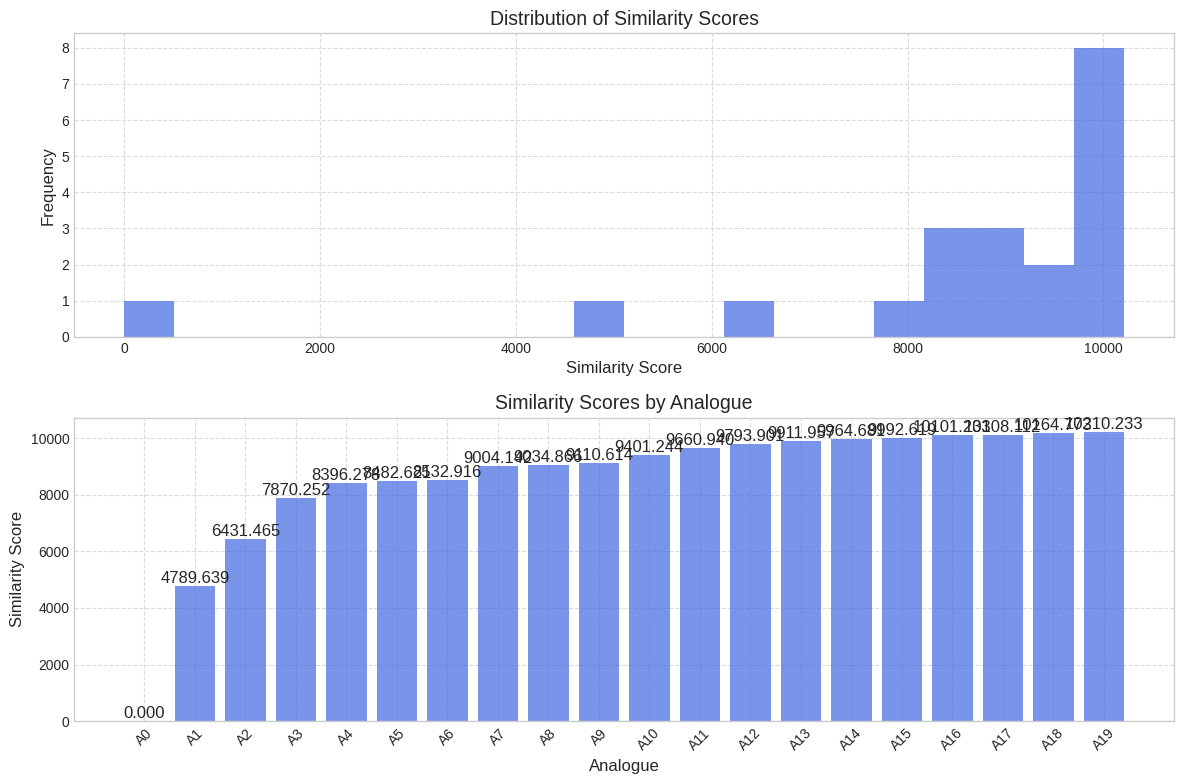

=== Similarity Score Statistics ===
Number of analogues: 20
Mean score: 8548.1243
Median score: 9255.9290
Standard deviation: 2372.9568
Min score: 0.0000
Max score: 10210.2330

=== Top 5 Analogues ===
Analogue 0: 2011-08-07: Score = 0.0000
Analogue 5: 2011-08-07: Score = 4789.6390
Analogue 7: 2011-08-07: Score = 6431.4653
Analogue 8: 2011-08-07: Score = 7870.2515
Analogue 10: 2019-08-07: Score = 8396.2780


In [20]:
def analyze_score_distribution(results, max_analogues=20):
    """
    Analyze and visualize the distribution of similarity scores in the analogues.
    
    Args:
        results (dict or list): Loaded analogue results
        max_analogues (int): Maximum number of analogues to include in visualization
        
    Returns:
        None: This function produces visualizations directly
    """
    if results is None:
        print("No results available to analyze.")
        return
    
    # Extract scores based on result structure
    scores = []
    labels = []
    
    if isinstance(results, dict):
        # Single event results
        for key in results:
            if key != "target_event" and isinstance(results[key], dict) and "score" in results[key]:
                # Ensure score is a float
                try:
                    score = float(results[key]["score"])
                    scores.append(score)
                    # Create label with analogue index and date
                    start_time = results[key]["start_time"]
                    label = f"Analogue {key}: {start_time.strftime('%Y-%m-%d')}"
                    labels.append(label)
                except (ValueError, TypeError):
                    print(f"Warning: Could not convert score for key {key} to float: {results[key]['score']}")
    elif isinstance(results, list):
        # Multiple event results (take first event for visualization)
        event_results = results[0]
        for key in event_results:
            if key != "target_event" and isinstance(event_results[key], dict) and "score" in event_results[key]:
                # Ensure score is a float
                try:
                    score = float(event_results[key]["score"])
                    scores.append(score)
                    # Create label with analogue index and date
                    start_time = event_results[key]["start_time"]
                    label = f"Analogue {key}: {start_time.strftime('%Y-%m-%d')}"
                    labels.append(label)
                except (ValueError, TypeError):
                    print(f"Warning: Could not convert score for key {key} to float: {event_results[key]['score']}")
    
    # Check if we have any valid scores
    if not scores:
        print("No valid scores found for analysis.")
        return
    
    # Limit to max_analogues
    if len(scores) > max_analogues:
        scores = scores[:max_analogues]
        labels = labels[:max_analogues]
    
    # Create visualizations
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Score distribution histogram
    plt.subplot(2, 1, 1)
    plt.hist(scores, bins=min(20, len(scores)), alpha=0.7, color='royalblue')
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Score by analogue (bar chart)
    plt.subplot(2, 1, 2)
    indices = range(len(scores))
    bars = plt.bar(indices, scores, color='royalblue', alpha=0.7)
    plt.title('Similarity Scores by Analogue')
    plt.xlabel('Analogue')
    plt.ylabel('Similarity Score')
    plt.xticks(indices, [f"A{i}" for i in indices], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== Similarity Score Statistics ===")
    print(f"Number of analogues: {len(scores)}")
    print(f"Mean score: {np.mean(scores):.4f}")
    print(f"Median score: {np.median(scores):.4f}")
    print(f"Standard deviation: {np.std(scores):.4f}")
    print(f"Min score: {np.min(scores):.4f}")
    print(f"Max score: {np.max(scores):.4f}")
    
    # Top 5 analogues with details
    print("\n=== Top 5 Analogues ===")
    for i in range(min(5, len(labels))):
        print(f"{labels[i]}: Score = {scores[i]:.4f}")

# Analyze score distribution
if loaded_results is not None:
    analyze_score_distribution(loaded_results)

### Temporal Analysis of Analogues

We analyze the temporal distribution of analogues to identify seasonal patterns or clustering.

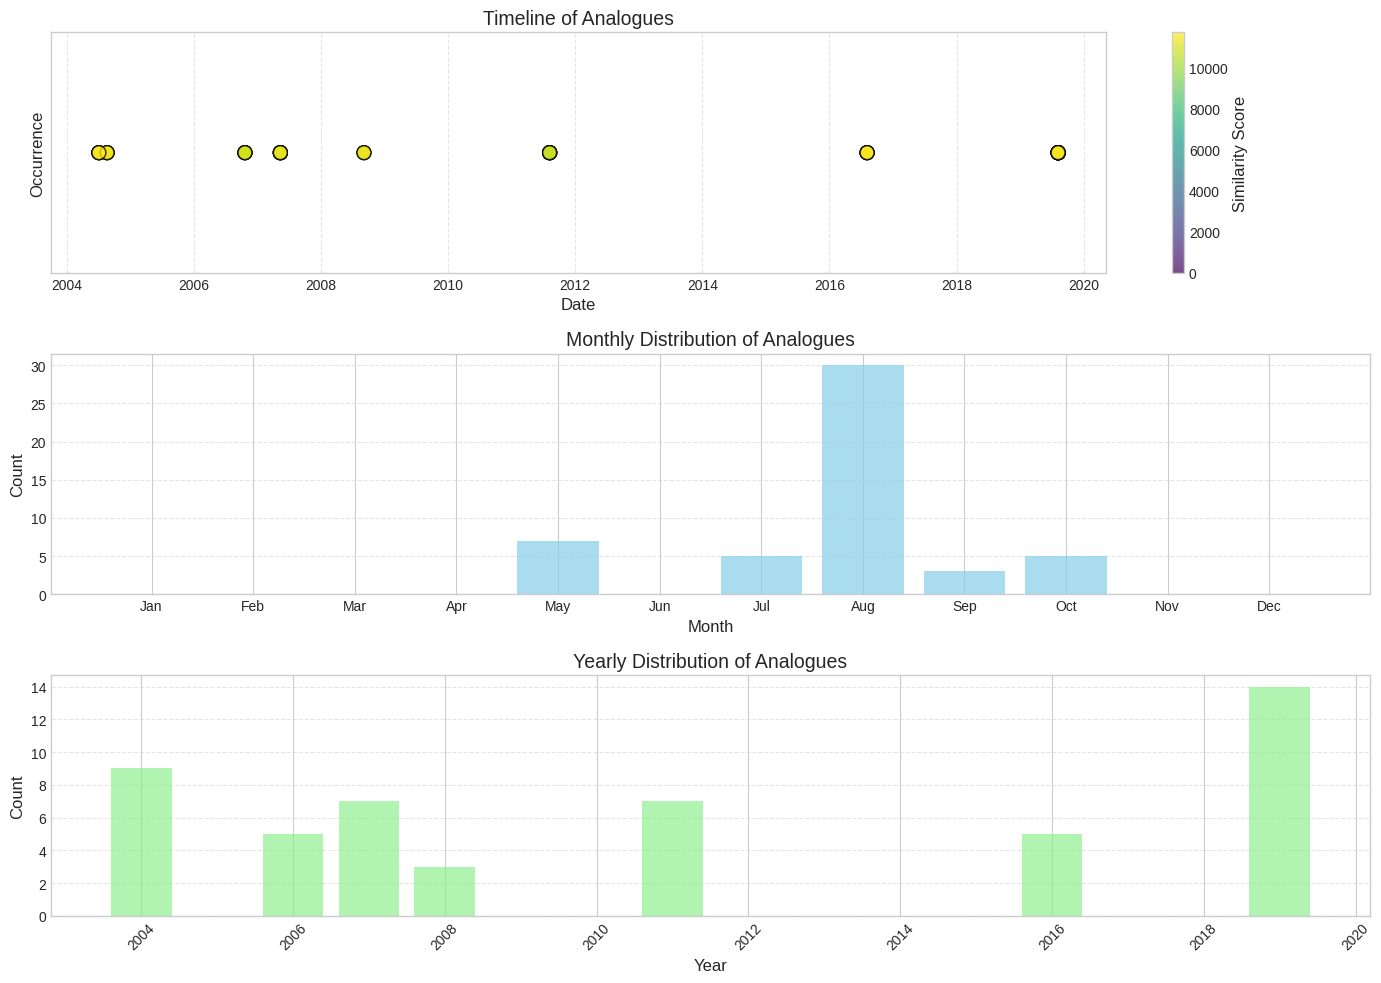

=== Temporal Analysis of Analogues ===
Number of analogues: 50
Date range: 2004-07-03 12:00:00 to 2019-08-07 14:00:00

=== Seasonal Distribution ===
Summer: 35 analogues (70.0%)
Fall: 8 analogues (16.0%)
Spring: 7 analogues (14.0%)


In [21]:
def analyze_temporal_distribution(results, max_analogues=50):
    """
    Analyze and visualize the temporal distribution of analogues.
    
    Args:
        results (dict or list): Loaded analogue results
        max_analogues (int): Maximum number of analogues to include in visualization
        
    Returns:
        None: This function produces visualizations directly
    """
    if results is None:
        print("No results available to analyze.")
        return
    
    # Extract timestamps based on result structure
    timestamps = []
    scores = []
    
    if isinstance(results, dict):
        # Single event results
        target_date = None
        if "target_event" in results and "start_time" in results["target_event"]:
            target_date = results["target_event"]["start_time"]
        
        for key in results:
            if key != "target_event" and isinstance(results[key], dict) and "start_time" in results[key]:
                timestamps.append(results[key]["start_time"])
                # Ensure score is a float
                try:
                    score = float(results[key]["score"])
                    scores.append(score)
                except (ValueError, TypeError):
                    # Use a default score if conversion fails
                    scores.append(0.0)
                    print(f"Warning: Could not convert score for key {key} to float: {results[key]['score']}")
    elif isinstance(results, list):
        # Multiple event results (take first event for visualization)
        event_results = results[0]
        target_date = None
        if "target_event" in event_results and "start_time" in event_results["target_event"]:
            target_date = event_results["target_event"]["start_time"]
            
        for key in event_results:
            if key != "target_event" and isinstance(event_results[key], dict) and "start_time" in event_results[key]:
                timestamps.append(event_results[key]["start_time"])
                # Ensure score is a float
                try:
                    score = float(event_results[key]["score"])
                    scores.append(score)
                except (ValueError, TypeError):
                    # Use a default score if conversion fails
                    scores.append(0.0)
                    print(f"Warning: Could not convert score for key {key} to float: {event_results[key]['score']}")
    
    # Check if we have any valid timestamps
    if not timestamps:
        print("No valid timestamps found for analysis.")
        return
    
    # Limit to max_analogues
    if len(timestamps) > max_analogues:
        timestamps = timestamps[:max_analogues]
        scores = scores[:max_analogues]
    
    # Convert to pandas Series for easier analysis
    ts_series = pd.Series(timestamps)
    
    # Create visualizations
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Timeline of analogues
    plt.subplot(3, 1, 1)
    plt.scatter(timestamps, [1] * len(timestamps), c=scores, cmap='viridis', 
                s=100, alpha=0.7, edgecolors='k')
    
    if target_date is not None:
        plt.axvline(x=target_date, color='r', linestyle='--', label='Target Event')
    
    plt.title('Timeline of Analogues')
    plt.xlabel('Date')
    plt.ylabel('Occurrence')
    plt.yticks([])  # Hide y-axis ticks
    plt.colorbar(label='Similarity Score')
    plt.grid(True, linestyle='--', alpha=0.5)
    if target_date is not None:
        plt.legend()
    
    # Plot 2: Monthly distribution
    plt.subplot(3, 1, 2)
    monthly_counts = ts_series.dt.month.value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Create a DataFrame with all months
    all_months = pd.DataFrame({'Month': range(1, 13)})
    monthly_counts = all_months.set_index('Month').join(
        monthly_counts.rename('Count')).fillna(0)['Count']
    
    bars = plt.bar(month_names, monthly_counts, color='skyblue', alpha=0.7)
    
    # Highlight target event month if available
    if target_date is not None:
        target_month = target_date.month - 1  # 0-based index for list
        bars[target_month].set_color('indianred')
        bars[target_month].set_alpha(1.0)
    
    plt.title('Monthly Distribution of Analogues')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.5, axis='y')
    
    # Plot 3: Yearly distribution
    plt.subplot(3, 1, 3)
    yearly_counts = ts_series.dt.year.value_counts().sort_index()
    
    bars = plt.bar(yearly_counts.index, yearly_counts, color='lightgreen', alpha=0.7)
    
    # Highlight target event year if available
    if target_date is not None:
        target_year = target_date.year
        if target_year in yearly_counts.index:
            idx = list(yearly_counts.index).index(target_year)
            bars[idx].set_color('indianred')
            bars[idx].set_alpha(1.0)
    
    plt.title('Yearly Distribution of Analogues')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.5, axis='y')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== Temporal Analysis of Analogues ===")
    print(f"Number of analogues: {len(timestamps)}")
    print(f"Date range: {min(timestamps)} to {max(timestamps)}")
    
    # Season distribution
    season_mapping = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    }
    
    seasons = [season_mapping[date.month] for date in timestamps]
    season_counts = pd.Series(seasons).value_counts()
    
    print("\n=== Seasonal Distribution ===")
    for season, count in season_counts.items():
        print(f"{season}: {count} analogues ({count/len(timestamps)*100:.1f}%)")
    
    # Target event season if available
    if target_date is not None:
        target_season = season_mapping[target_date.month]
        print(f"\nTarget event season: {target_season}")

# Analyze temporal distribution
if loaded_results is not None:
    analyze_temporal_distribution(loaded_results)


### Visualization of Analogue Weather Patterns

We visualize the actual weather patterns of the top analogues to understand their similarities
and differences with the target event.

In [24]:
def visualize_analogues(results, atmosphere_data, timestamps, top_n=5):
    """
    Visualize the weather patterns of the top analogues compared to the target event.
    
    Args:
        results (dict or list): Loaded analogue results
        atmosphere_data (torch.Tensor): The original atmospheric data tensor
        timestamps (list): List of timestamp strings
        top_n (int): Number of top analogues to visualize
        
    Returns:
        None: This function produces visualizations directly
    """
    if results is None or atmosphere_data is None:
        print("Results or atmosphere data not available for visualization.")
        return
    
    # Extract information based on result structure
    target_data = None
    analogue_data = []
    analogue_labels = []
    
    # Convert timestamps to numpy datetime for searching
    timestamps_array = pd.to_datetime(timestamps).to_numpy()
    
    if isinstance(results, dict):
        # Single event results
        target_date = None
        if "target_event" in results and "start_time" in results["target_event"]:
            target_date = results["target_event"]["start_time"]
            # Find target data
            target_idx = np.searchsorted(timestamps_array, np.datetime64(target_date))
            if target_idx < len(atmosphere_data):
                target_data = atmosphere_data[target_idx].numpy()
        
        # Find analogue data
        count = 0
        # Get all keys except 'target_event', convert to integers if possible, and sort
        sorted_keys = []
        for key in results.keys():
            if key != "target_event":
                try:
                    sorted_keys.append(int(key))
                except (ValueError, TypeError):
                    sorted_keys.append(key)
        sorted_keys.sort()
        
        for key in sorted_keys:
            if count >= top_n:
                break
                
            str_key = str(key)
            if isinstance(results[str_key], dict) and "start_time" in results[str_key]:
                analogue_date = results[str_key]["start_time"]
                analogue_idx = np.searchsorted(timestamps_array, np.datetime64(analogue_date))
                
                if analogue_idx < len(atmosphere_data):
                    analogue_data.append(atmosphere_data[analogue_idx].numpy())
                    date_str = analogue_date.strftime('%Y-%m-%d')
                    
                    # Convert score to float if it's a string
                    try:
                        score = float(results[str_key]["score"])
                        score_str = f"{score:.4f}"
                    except (ValueError, TypeError):
                        # Use the original score as string if conversion fails
                        score_str = str(results[str_key]["score"])
                    
                    analogue_labels.append(f"Analogue {key}: {date_str} (Score: {score_str})")
                    count += 1
    
    elif isinstance(results, list):
        # Multiple event results (take first event for visualization)
        event_results = results[0]
        target_date = None
        if "target_event" in event_results and "start_time" in event_results["target_event"]:
            target_date = event_results["target_event"]["start_time"]
            # Find target data
            target_idx = np.searchsorted(timestamps_array, np.datetime64(target_date))
            if target_idx < len(atmosphere_data):
                target_data = atmosphere_data[target_idx].numpy()
        
        # Find analogue data
        count = 0
        # Get all keys except 'target_event', convert to integers if possible, and sort
        sorted_keys = []
        for key in event_results.keys():
            if key != "target_event":
                try:
                    sorted_keys.append(int(key))
                except (ValueError, TypeError):
                    sorted_keys.append(key)
        sorted_keys.sort()
        
        for key in sorted_keys:
            if count >= top_n:
                break
                
            str_key = str(key)
            if isinstance(event_results[str_key], dict) and "start_time" in event_results[str_key]:
                analogue_date = event_results[str_key]["start_time"]
                analogue_idx = np.searchsorted(timestamps_array, np.datetime64(analogue_date))
                
                if analogue_idx < len(atmosphere_data):
                    analogue_data.append(atmosphere_data[analogue_idx].numpy())
                    date_str = analogue_date.strftime('%Y-%m-%d')
                    
                    # Convert score to float if it's a string
                    try:
                        score = float(event_results[str_key]["score"])
                        score_str = f"{score:.4f}"
                    except (ValueError, TypeError):
                        # Use the original score as string if conversion fails
                        score_str = str(event_results[str_key]["score"])
                    
                    analogue_labels.append(f"Analogue {key}: {date_str} (Score: {score_str})")
                    count += 1
    
    # Check if we have data to visualize
    if target_data is None or len(analogue_data) == 0:
        print("No data available for visualization.")
        return
    
    # Define variable names for plot titles
    variable_names = ["Dew Point Temp (d2m)", "U Wind Component (u)", 
                     "V Wind Component (v)", "Mean Sea Level Pressure (msl)", 
                     "Relative Humidity (r)"]
    
    # Create visualization grid
    num_variables = target_data.shape[0]
    num_rows = top_n + 1  # Target + analogues
    
    fig, axes = plt.subplots(num_rows, num_variables, figsize=(20, 4 * num_rows))
    
    # Standardize color scale across all plots
    vmin_list = []
    vmax_list = []
    
    # Calculate min and max for each variable
    for var_idx in range(num_variables):
        all_var_data = [target_data[var_idx]]
        for ana_data in analogue_data:
            all_var_data.append(ana_data[var_idx])
        
        vmin = min(data.min() for data in all_var_data)
        vmax = max(data.max() for data in all_var_data)
        vmin_list.append(vmin)
        vmax_list.append(vmax)
    
    # Plot target data (first row)
    for var_idx in range(num_variables):
        ax = axes[0, var_idx]
        im = ax.imshow(target_data[var_idx], cmap='viridis', 
                       vmin=vmin_list[var_idx], vmax=vmax_list[var_idx])
        ax.set_title(f"Target: {variable_names[var_idx]}")
        ax.axis('off')
        plt.colorbar(im, ax=ax)
    
    # Plot analogue data (subsequent rows)
    for row_idx, (ana_data, ana_label) in enumerate(zip(analogue_data, analogue_labels), 1):
        for var_idx in range(num_variables):
            ax = axes[row_idx, var_idx]
            im = ax.imshow(ana_data[var_idx], cmap='viridis',
                          vmin=vmin_list[var_idx], vmax=vmax_list[var_idx])
            
            # Only add title to first variable in row
            if var_idx == 0:
                ax.set_title(f"{ana_label}\n{variable_names[var_idx]}")
            else:
                ax.set_title(f"{variable_names[var_idx]}")
                
            ax.axis('off')
            plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.suptitle("Comparison of Target Event and Top Analogues", fontsize=16, y=1.02)
    plt.show()

# Visualize analogues if data is available
if loaded_results is not None and atmosphere_data_tensor is not None:
    visualize_analogues(loaded_results, atmosphere_data_tensor, timestamps, top_n=3)


No data available for visualization.


## Summary and Conclusion

In this notebook, we have implemented machine learning-based methods for finding weather analogues using the Atmodist model. The key components of our approach are:

1. **Data and Model Preparation**:
   - We loaded ERA5 reanalysis data with appropriate preprocessing
   - We extracted embeddings using a pre-trained Atmodist model
   - We organized historical flood events for target selection

2. **Analogue Search Strategies**:
   - Batch processing to find analogues for all events
   - Single event analysis for detailed investigation
   - Event-constrained search to limit analogues to known historical events

3. **Analysis and Visualization**:
   - Score distribution analysis to assess match quality
   - Temporal analysis to identify seasonal patterns
   - Visualization of weather patterns for direct comparison

The ML-based approach offers several advantages over traditional metric-based analogue searching:

- It captures complex, non-linear relationships in atmospheric data
- The embedding space efficiently represents key weather patterns
- The approach is more computationally efficient for large datasets
- It can potentially identify analogues that traditional metrics might miss

This methodology can be applied to various weather-related applications, including:

- Flood risk assessment and forecasting
- Climate change impact studies
- Historical weather pattern analysis
- Extreme event prediction and planning

Future work could focus on:
- Comparing ML-based analogues with those found using traditional metrics
- Fine-tuning the embedding extraction for specific weather phenomena
- Incorporating additional data sources for more comprehensive analogues
- Developing hybrid approaches that combine ML and physical metrics